## Amdahl's and Strong Scaling  

Amdahl's law is the fundamental principle behind _strong scaling_ in parallel computing.  
Strong scaling is the process of solving a problem of the _fixed size_ faster with parallel resources.  The improvement in performance is measured as _speedup_.  

  * $T(1)$ = time to execute task on a single resource
  * $T(n)$ = time to execute task on n resources
  * Speedup = $T(1)/T(n)$

Examples include:

  * parallel data analysis for high-frequency trading
  * key cracking in cryptosystems
  * training a deep-neural network on a corpus of examples
  
In all, the data remains the same size and the goal is to complete the computation faster.
 
_Activity_: write down an example problem that would benefit from speedup.

### Concepts in this unit
  * Amdahl's law
  * strong scaling
  * speedup
  * speedup estimation
  
### Outcomes
The ability to apply Amdahl's in both directions:
  * to estimate scalability parameters based on a black box implementation of a parallel program
  * to estimate how a given problem will scale based on an instrumentation of a serial program

## Amdahl's Law 

Improving a portion $p$ of a computation by factor $s$ results in an overall speedup of

$$S_{\mbox{latency}}(s) = \frac{1}{1-p+\frac{p}{s}}$$

* _p_ is the proportion of execution time that benefits from improved resources, i.e. the parallel part
* _(1-p)_ is the portion that does not benefit; i.e. the serial part
* _s_ is the speedup of the optimized part
* _S<sub>latency</sub>(s)_ theoretical speedup of the whole task

Paraphrased: speedup limited to fraction improved

<img src="./old/images/al2.png" width="512" title="Amdahl's Law Graph (from Greg Ganger)" />

### Visualizing Amdahl's Law

Let's look at the Amdahl curve for a given parallel fraction (.95).


In [9]:
import numpy as np
import pandas as pd

resources = np.array(range(1,65))
p=0.95

dfdata = {'resources': resources, 'speedup': 1/((1-p)+p/resources)}
df = pd.DataFrame(dfdata)
df

,resources,speedup
0,1,1.000000
1,2,1.904762
2,3,2.727273
3,4,3.478261
4,5,4.166667
...,...,...
59,60,15.189873
60,61,15.250000
61,62,15.308642
62,63,15.365854


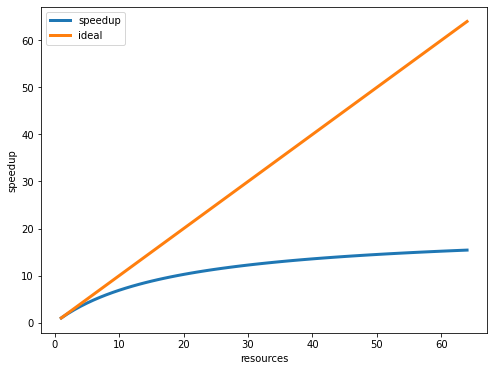

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(df.resources, df.speedup, linewidth=3, label='speedup')
plt.plot(df.resources, df.resources, linewidth=3, label='ideal')
plt.xlabel('resources')
plt.ylabel('speedup')
plt.legend()
plt.show()

#### Linear (Ideal) Speedup

According to Amdahl's law, the best speedup is achieved when $p=1$ and $S=s$.
  * entire computation optimized
  * doubling resources doubles speed
 
This is the efficiency limit and is often plotted in speedup charts to see the loss of parallelism.

#### Properties of a Speedup Plot

* x-axis should have resources
* y-axis should be speedup ($T(1)/T(n)$)
* axes should be linear-linear or log-log (log-log more common)

Let's compare with log-log. Same "shape", different scale.

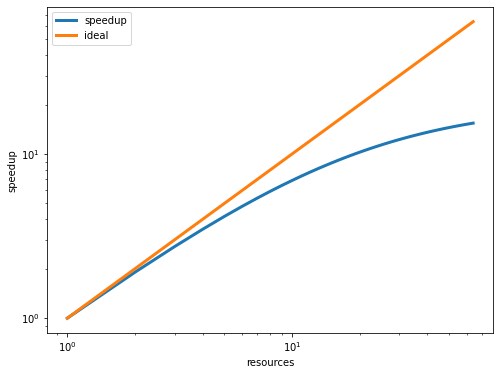

In [12]:
plt.figure(figsize=(8,6))
plt.plot(df.resources, df.speedup, linewidth=3, label='speedup')
plt.plot(df.resources, df.resources, linewidth=3, label='ideal')
plt.xlabel('resources')
plt.ylabel('speedup')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

### Scaling

Let's now look at how performance scales as function of the parallel fraction.


<Figure size 576x432 with 0 Axes>

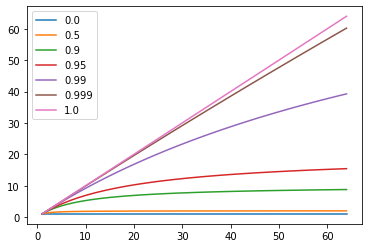

<Figure size 576x432 with 0 Axes>

In [14]:
%matplotlib inline

from itertools import product
import numpy as np
import pandas as pd

resources = range(1,65)
p = [0,.5,.9,.95,.99,.999, 1.0]

data_arr = np.empty((len(resources), len(p)))

#initialize array -- using embedded for loops
#for i in range(len(p)):
#    for j in range(len(resources)):
#        data_arr[i,j] = 1/(1-p[i]+p[i]/resources[j])  
        
# initiliaze array using numpy indexing
for i,j in np.ndindex(data_arr.shape):
    data_arr[i,j] = 1/(1-p[j]+p[j]/resources[i])  
    
# RB I tried to fool around with map/vectorize here and failed.

df = pd.DataFrame(data=data_arr, index=resources, columns=p)
df.plot()

### Amdahl's law defeats parallel performance

The graph indicates that even a small amount of inefficiency reduces scaleup at a modest amount of parallelism.
Let's look at this the other way around.

* Suppose you want to achieve a speedup of 80 with 100 processors, what fraction of the original computation must be optimized?

In [5]:
# 80 = 1 / ((1-p)+p/100)
p = (100-100/80)/99
p

0.9974747474747475

So, about $1/4$ of one percent can be unoptimized (or serial). Not much!  This is the downfall of parallelism.

#### So what is serial?

We say 'serial' as a simple abstraction for the unoptimized portion.  Its an abstraction to reason about parallelism.
* Sometimes literal:
  * Code running in a single thread before the parallel part starts
  * File I/O before launching a program
* Sometimes metaphorical:
  * When one/few processes are running while others are idle 
  * When parallelism introduces additional computation

The unoptimized fraction of the code occurs
when not all resources are doing useful work at full capacity.

### Inferring parallelism from Amdahl's Law

Simplifying unoptimized into serial and parallel allows us to infer an __Amdahl Number__ from 
the empirical performance of a code.

In [15]:
# we measure perforamnce as a function of processors. 
processors = np.array([2,4,8,16,32])
speedup = np.array([1.85, 3.30, 5.34, 7.4, 9.4])
amdahl_number = processors/(processors-1)*(1-1/speedup)
amdahl_number

array([0.91891892, 0.92929293, 0.92883895, 0.92252252, 0.92244338])

So, we would say that this code seems to have an Amdahl # of about .92.  The can be converted into a maximum possible speedup.

* Amdahl's law implies that the unoptimized fraction of the code dictates exactly how much speedup can be obtained on __an infinite number of cores__.

$$S_{\mbox{latency}}(s) = \frac{1}{1-p+\frac{p}{\infty}} = \frac{1}{1-p}$$

In [7]:
slim = 1/(1-0.92)
slim

12.500000000000007

Lets look at this limit on the speedup plot.

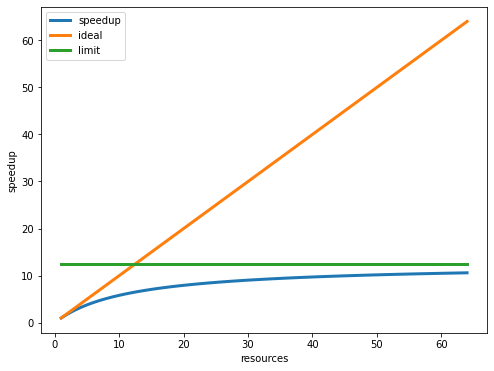

In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

resources = np.array(range(1,65))
p=0.92

dfdata = {'resources': resources, 'speedup': 1/((1-p)+p/resources)}
df = pd.DataFrame(dfdata)

%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(df.resources, df.speedup, linewidth=3, label='speedup')
plt.plot(df.resources, df.resources, linewidth=3, label='ideal')
plt.plot(df.resources, slim + 0*df.resources, linewidth=3, label='limit')
plt.xlabel('resources')
plt.ylabel('speedup')
plt.legend()
plt.show()

_Activity_: Given the fraction of serial computation that is optimized and unoptimized for the following code snippet
<code>
    
    // 2% of serial execution spent outside of the loop
    ...some computation here...

    // 98% of serial execution spent in this loop that is parallelized
    #pragma omp parallel for 
    for (int i=0; i<N; i++ )
    { 
        ...other computation here...
    }
</code> 

__draw a speedup chart__ that includes
  - 3 points on the Amdahl's law curve (give exact values),
  - include the line of ideal parallelism that serves as an upper
    bound for all speedup, and 
  - include the asymptote for the maximum possible speedup
    for this code.

## Parting Thoughts

Performance in practice is much more complex than splitting a code into a "unoptimized" and "optimized" portion.  But we will see that Amdahl's law is incredibly useful in:
  * Back of the envelope calculations about scalability limits (setting a speed limit)
  * Deciding what portions of a complex software application is worth optimizing
  
A typical optimization process for a piece of software
  * implement a serial solution
  * instrument/profile code to determine how much time is spent in what steps
  * optimize only the expensive steps 
    * it's hard work writing parallel programs (10x harder than serial)
    * or choose not to parallelize, because the speedup limit is not good enough
    
So we use Amdahl's law to:
  * choose whether to parallelize a solution
  * pick what part of our program to optimize